In [1]:
%run LaSEL_Functions.ipynb

In [2]:
import pandas as pd
import pypyodbc as odbc
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import pvlib
import pvanalytics
import sklearn.metrics
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import seaborn as sns
#plotting format
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size']=12
plt.rcParams['lines.linewidth']=1.25
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.titlesize']=12
pd.options.mode.chained_assignment = None

In [3]:
lasel_cursor = connect_server(driver_name = 'SQL Server', server_name = '192.168.1.109', database_name = 'EI', uid = 'GradStudent', password = '1000W/m2')

In [4]:
cols1 = ["TmStamp", "BOM_temp_C_Avg", "inv_dc_power_Avg_22" , "inv_dc_power_Avg_36", "inv_dc_power_Avg_39"]
table1 = 'dbo.Draker_OneMinINVDC02'
cols2 = ["TmStamp", "Global_Avg" , "DNI_Avg", "Diffused_Avg" , "RH", "AirTC_Avg" , "WS_ms_Avg", "CMP10POA_Avg"]
table2 = 'dbo.CR1000XMETStation_OneMin'
start = '2023-04-01' 
end ='2024-04-01'
sys_met_df = read_two_tables(lasel_cursor, table1, table2, start, end, cols1, cols2)

IndexError: index 11 is out of bounds for axis 0 with size 11

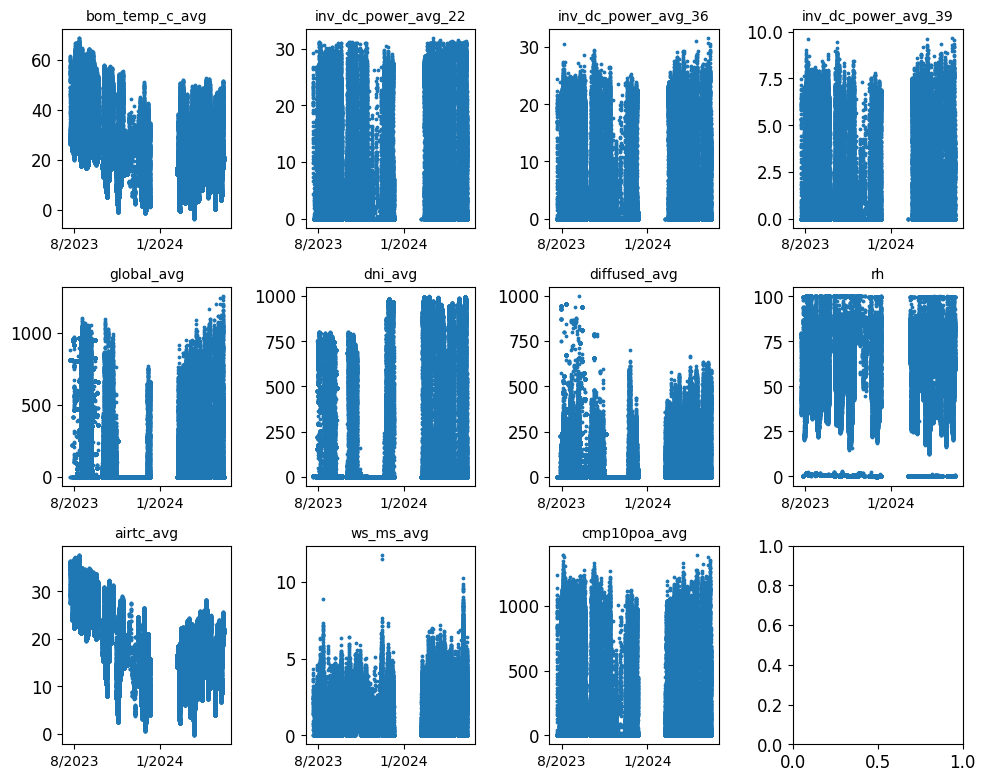

In [5]:
fig, ax = plt.subplots(3,4, sharex=False, sharey=False, figsize=(10, 8))
columns = sys_met_df.columns
p=0
fig.tight_layout(pad=1.5)
for i in range(3):
    for j in range(4):
        ax[i,j].scatter(x=sys_met_df.index, y=sys_met_df[columns[p]], s=3)
        ax[i,j].set_title(columns[p], fontsize=10)
        ax[i,j].set_xticks(ticks = [ax[i,j].get_xticks()[0],ax[i,j].get_xticks()[4]], labels=['8/2023', '1/2024'], fontsize=10)
        p = p+1


plt.show()

In [6]:
sys_met_df_clean = sys_met_df.replace(0, np.nan)

In [7]:
sys_met_df_clean['month'] = sys_met_df_clean.index.month
sys_met_df_clean['hour'] = sys_met_df_clean.index.hour
sys_met_df_clean['day'] = sys_met_df_clean.index.day

In [8]:
sdf = pvlib.solarposition.get_solarposition(time=sys_met_df_clean.index, latitude=30.22, 
        longitude=-92.04,temperature=sys_met_df_clean['airtc_avg'], altitude=15)
sdf['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=sys_met_df_clean.index)

In [9]:
consis, ratio = pvanalytics.quality.irradiance.check_irradiance_consistency_qcrad(solar_zenith = sdf['apparent_zenith'], ghi=sys_met_df_clean['global_avg'], 
                                                                  dhi=sys_met_df_clean['diffused_avg'], dni=sys_met_df_clean['dni_avg'])
sys_met_df_clean['consistency filt'] = consis
sys_met_df_clean = sys_met_df_clean.loc[sys_met_df_clean['consistency filt'] == True]

Text(0, 0.5, 'cmp10poa_avg')

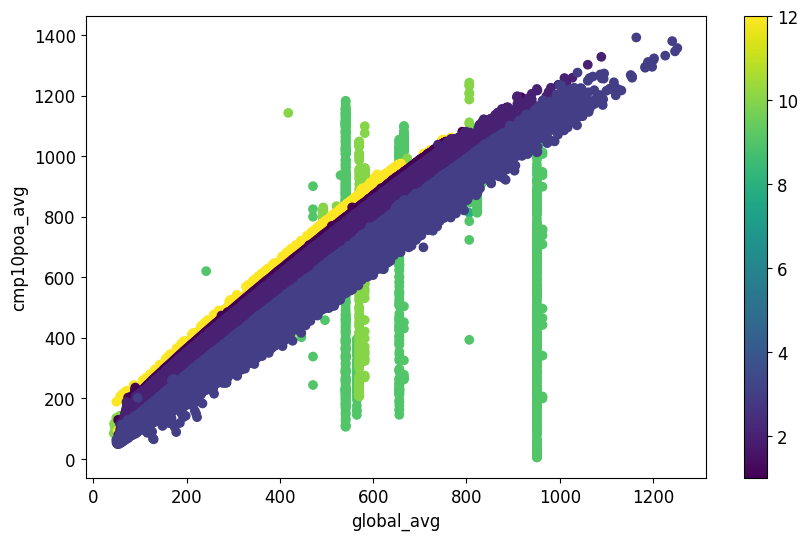

In [10]:
sp = plt.scatter(sys_met_df_clean['global_avg'], sys_met_df_clean['cmp10poa_avg'], c=sys_met_df_clean.index.month)
plt.colorbar(sp)
plt.xlabel('global_avg')
plt.ylabel('cmp10poa_avg')

In [11]:
sys_met_df_clean['global filt'] = np.where(sys_met_df_clean['global_avg'].diff() == 0, 0, 1)

Text(0, 0.5, 'cmp10poa_avg')

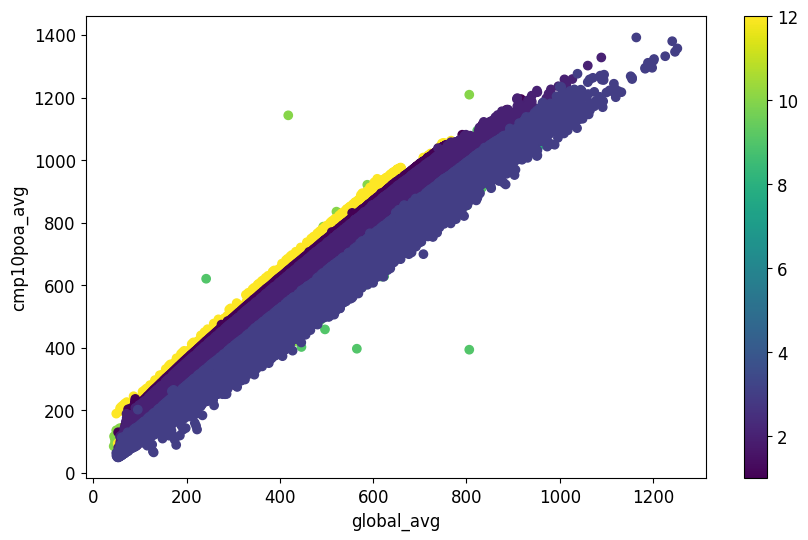

In [12]:
sp = plt.scatter(sys_met_df_clean.loc[sys_met_df_clean['global filt'] == 1]['global_avg'], sys_met_df_clean.loc[sys_met_df_clean['global filt'] == 1]['cmp10poa_avg'], c=sys_met_df_clean.loc[sys_met_df_clean['global filt'] == 1].index.month)
plt.colorbar(sp)
plt.xlabel('global_avg')
plt.ylabel('cmp10poa_avg')

In [13]:
sys_met_df_clean.columns

Index(['bom_temp_c_avg', 'inv_dc_power_avg_22', 'inv_dc_power_avg_36',
       'inv_dc_power_avg_39', 'global_avg', 'dni_avg', 'diffused_avg', 'rh',
       'airtc_avg', 'ws_ms_avg', 'cmp10poa_avg', 'month', 'hour', 'day',
       'consistency filt', 'global filt'],
      dtype='object')

In [14]:
sys_met_df_clean['inv22_p'] = sys_met_df_clean['inv_dc_power_avg_22']#['inv_dc_voltage_01_avg_22'] * sys_met_df_clean['inv_dc_current_01_avg_22']
sys_met_df_clean['inv36_p'] = sys_met_df_clean['inv_dc_power_avg_36']#['inv_dc_voltage_avg_36'] * sys_met_df_clean['inv_dc_current_avg_36']
sys_met_df_clean['inv39_p'] = sys_met_df_clean['inv_dc_power_avg_39']#['inv_dc_voltage_avg_39'] * sys_met_df_clean['inv_dc_current_avg_39']

In [15]:
from_ts = '2024-02-01 00:00:00'
to_ts = '2024-02-07 23:59:00'
sys_met_df_clean = sys_met_df_clean[(sys_met_df_clean.index < from_ts) | (sys_met_df_clean.index > to_ts)]

In [16]:
sys_met_df_clean = sys_met_df_clean.loc[(sys_met_df_clean['global filt'] == 1)]
sys_met_df_clean.loc[(sys_met_df_clean['cmp10poa_avg'] < 50) | (sys_met_df_clean['global_avg'] < 50) | (sys_met_df_clean['dni_avg'] < 1)] = np.nan

C:\Users\lelia\AppData\Local\Temp\ipykernel_67448\2873959571.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  sys_met_df_clean.loc[(sys_met_df_clean['cmp10poa_avg'] < 50) | (sys_met_df_clean['global_avg'] < 50) | (sys_met_df_clean['dni_avg'] < 1)] = np.nan


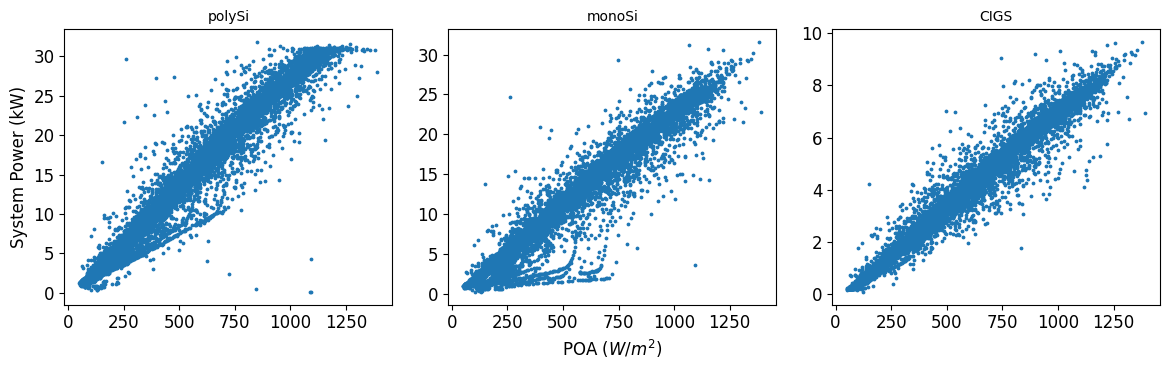

In [17]:
fig, ax = plt.subplots(1,3, sharex=False, sharey=False, figsize=(12, 4))
systems = ['inv22_p', 'inv36_p', 'inv39_p']
titles = ['polySi', 'monoSi', 'CIGS']
p=0
for j in range(3):
    ax[j].scatter(x=sys_met_df_clean['cmp10poa_avg'], y=sys_met_df_clean[systems[p]], s=3)
    ax[j].set_title(titles[p], fontsize=10)
    if j==0:
        ax[j].set_ylabel('System Power (kW)')
    if j==1:
        ax[j].set_xlabel('POA ($W/m^2$)')
    # ax[0,j].set_xticks(ticks = [ax[i,j].get_xticks()[0],ax[i,j].get_xticks()[4]], labels=['8/2023', '1/2024'], fontsize=10)
    p = p+1

fig.tight_layout(pad=1.5)
plt.show()


In [18]:
edf = pvlib.irradiance.get_total_irradiance(surface_tilt=35, surface_azimuth=180, 
        solar_zenith=sdf['apparent_zenith'], solar_azimuth=sdf['azimuth'],dni=sys_met_df_clean['dni_avg'],
        ghi=sys_met_df_clean['global_avg'], dhi=sys_met_df_clean['diffused_avg'], dni_extra=sdf['dni_extra'], model ='haydavies')
edf['aoi'] = pvlib.irradiance.aoi(surface_tilt=35, surface_azimuth=180, 
        solar_zenith=sdf['apparent_zenith'], solar_azimuth=sdf['azimuth'])
edf['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=sdf['apparent_zenith'])
edf['am_abs'] = pvlib.atmosphere.get_absolute_airmass(airmass_relative=edf['airmass'], pressure=pvlib.atmosphere.alt2pres(15))

In [19]:
inv22_mod =  {
  "pmp": 325,
  "vmp": 36.0,
  "imp": 9.03,
  "voc": 44.6,
  "isc": 9.74,
  "eff": 16.74,
  "ncells": 72,
  "mass": 22.5,
  "area" : 1.941,
  "width" : 0.992,
  "length" : 1.957,
  "gammapmp": -0.43,
  "alphaisc": 0.0045778,
  "betavoc": -0.14272,
  "strlen1" : 18,
  "nstr1" : 6,
  "strlen2" : np.nan,
  "nstr2" : np.nan,
  "name" : 'polySi'
}

inv36_mod =  {
  "pmp": 340,
  "vmp": 37.7,
  "imp": 9.02,
  "voc": 46.6,
  "isc": 9.32,
  "eff": 17.52,
  "ncells": 72,
  "mass": 23,
  "area" : 1.94,
  "width" : 1.008,
  "length" : 1.720,
  "gammapmp": -0.36,
  "alphaisc": 0.00466,
  "betavoc": -0.13048,
  "strlen1" : 28,
  "nstr1" : 2,
  "strlen2" : 30,
  "nstr2" : 1,
  "name" : 'monoSi'
}

inv39_mod =  {
  "pmp": 130,
  "vmp": 57,
  "imp": 2.28,
  "voc": 76.7,
  "isc": 2.6,
  "eff": 12,
  "ncells": 100,
  "mass": 16.8,
  "area" : 1.09,
  "width" : 0.656,
  "length" : 1.656,
  "gammapmp": -0.24,
  "alphaisc": 0.000104,
  "betavoc": -0.18408,
  "strlen1" : 78,
  "nstr1" : 2,
  "strlen2" : np.nan,
  "nstr2" : np.nan,
  "name" : 'cigs'
}

In [20]:
mods = [inv22_mod,inv36_mod,inv39_mod]

In [21]:
mod_data = pd.DataFrame(mods).transpose()
mod_data.rename(columns = {0:'polySi', 1:'monoSi', 2:'CIGS'}, inplace=True)

## Generating Model Results

Results are generated for 6 POA models, 6 module temp models, and 3 PV performance models

In [22]:
mod_names = ['polySi','monoSi','CIGS']
powers = [sys_met_df_clean['inv22_p'], sys_met_df_clean['inv36_p'], sys_met_df_clean['inv39_p']]

In [23]:
#recalc since length has changed due to filtering
sdf = pvlib.solarposition.get_solarposition(time=sys_met_df_clean.index, latitude=30.22, 
        longitude=-92.04,temperature=sys_met_df_clean['airtc_avg'], altitude=15)
sdf['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=sys_met_df_clean.index)
sdf['aoi'] = pvlib.irradiance.aoi(surface_tilt=35, surface_azimuth=180, 
        solar_zenith=sdf['apparent_zenith'], solar_azimuth=sdf['azimuth'])

In [24]:
ground_diffuse =  sys_met_df_clean['global_avg'] * 0.25 * (1 - np.cos(np.radians(35))) * 0.5
poa_direct = (sys_met_df_clean['dni_avg'] * np.cos(np.radians(sdf['aoi'])))
poa_direct[poa_direct < 0] = 0
sys_met_df_clean['dni_extra'] = pvlib.irradiance.get_extra_radiation(datetime_or_doy=sys_met_df_clean.index)
sys_met_df_clean['airmass'] = pvlib.atmosphere.get_relative_airmass(zenith=sdf['apparent_zenith'])

In [25]:
# perez coeffs testing
models = ['allsitescomposite1990','allsitescomposite1988','sandiacomposite1988','usacomposite1988','france1988','phoenix1988','elmonte1988','osage1988','albuquerque1988','capecanaveral1988','albany1988']
perez_solo = []
for model in models: 
    sky_diffuse = pvlib.irradiance.perez(surface_tilt = 35, surface_azimuth=180,
                    dhi=sys_met_df_clean['diffused_avg'],dni=sys_met_df_clean['dni_avg'], dni_extra=sys_met_df_clean['dni_extra'], solar_zenith=sdf['apparent_zenith'], 
                    solar_azimuth=sdf['azimuth'], airmass=sys_met_df_clean['airmass'], model = model)
    poa_diffuse = sky_diffuse + ground_diffuse
    perez_results = (poa_diffuse + poa_direct).to_frame()
    perez_results.rename(columns = {0:'Modeled POA'}, inplace=True)
    perez_results['Measured POA'] = sys_met_df_clean['cmp10poa_avg']
    perez_results['GHI'] = sys_met_df_clean['global_avg']
    perez_results['DNI'] = sys_met_df_clean['dni_avg']
    perez_results['DHI'] = sys_met_df_clean['diffused_avg']
    perez_results['Model'] = model
    perez_results['Time'] = sys_met_df_clean.index
    perez_solo.append(perez_results)
perez_solo_df = pd.concat(perez_solo)

In [26]:
#poa models
poa_results = []

#isotropic model
sky_diffuse = pvlib.irradiance.isotropic(surface_tilt = 35, dhi=sys_met_df_clean['diffused_avg'])
poa_diffuse = sky_diffuse + ground_diffuse
isotropic_results = (poa_diffuse + poa_direct).to_frame()
isotropic_results.rename(columns = { 0 :'Modeled POA'}, inplace=True)
isotropic_results['Measured POA'] = sys_met_df_clean['cmp10poa_avg']
isotropic_results['Model'] = 'Isotropic'
isotropic_results['Time'] = sys_met_df_clean.index
poa_results.append(isotropic_results)

#perez model
sky_diffuse = pvlib.irradiance.perez(surface_tilt = 35, surface_azimuth=180,
                dhi=sys_met_df_clean['diffused_avg'],dni=sys_met_df_clean['dni_avg'], dni_extra=sys_met_df_clean['dni_extra'], solar_zenith=sdf['apparent_zenith'], 
                solar_azimuth=sdf['azimuth'], airmass=sys_met_df_clean['airmass'], model = 'france1988')
poa_diffuse = sky_diffuse + ground_diffuse
perez_results = (poa_diffuse + poa_direct).to_frame()
perez_results.rename(columns = {0:'Modeled POA'}, inplace=True)
perez_results['Measured POA'] = sys_met_df_clean['cmp10poa_avg']
perez_results['Model'] = 'Perez (france1988)'
perez_results['Time'] = sys_met_df_clean.index
poa_results.append(perez_results)

#haydavies
sky_diffuse = pvlib.irradiance.haydavies(surface_tilt = 35, surface_azimuth=180, dhi=sys_met_df_clean['diffused_avg'],dni=sys_met_df_clean['dni_avg'], 
                        dni_extra=sys_met_df_clean['dni_extra'], solar_zenith=sdf['apparent_zenith'], solar_azimuth=sdf['azimuth'])
poa_diffuse = sky_diffuse + ground_diffuse
haydavies_results = (poa_diffuse + poa_direct).to_frame()
haydavies_results.rename(columns = {0:'Modeled POA'}, inplace=True)
haydavies_results['Measured POA'] = sys_met_df_clean['cmp10poa_avg']
haydavies_results['Model'] = 'Haydavies'
haydavies_results['Time'] = sys_met_df_clean.index
poa_results.append(haydavies_results)

#klucher
sky_diffuse = pvlib.irradiance.klucher(surface_tilt = 35, surface_azimuth=180, 
                dhi=sys_met_df_clean['diffused_avg'], ghi = sys_met_df_clean['global_avg'], solar_zenith = sdf['apparent_zenith'], solar_azimuth=sdf['azimuth'])
poa_diffuse = sky_diffuse + ground_diffuse
klucher_results = (poa_diffuse + poa_direct).to_frame()
klucher_results.rename(columns = {0:'Modeled POA'}, inplace=True)
klucher_results['Measured POA'] = sys_met_df_clean['cmp10poa_avg']
klucher_results['Model'] = 'Klucher'
klucher_results['Time'] = sys_met_df_clean.index
poa_results.append(klucher_results)

#reindl
sky_diffuse = pvlib.irradiance.reindl(surface_tilt = 35, surface_azimuth=180, 
                dhi=sys_met_df_clean['diffused_avg'],dni=sys_met_df_clean['dni_avg'], dni_extra=sys_met_df_clean['dni_extra'], ghi = sys_met_df_clean['global_avg'],
                solar_zenith = sdf['apparent_zenith'], solar_azimuth=sdf['azimuth'])
poa_diffuse = sky_diffuse + ground_diffuse
reindl_results = (poa_diffuse + poa_direct).to_frame()
reindl_results.rename(columns = {0:'Modeled POA'}, inplace=True)
reindl_results['Measured POA'] = sys_met_df_clean['cmp10poa_avg']
reindl_results['Model'] = 'Reindl'
reindl_results['Time'] = sys_met_df_clean.index
poa_results.append(reindl_results)

#king
sky_diffuse = pvlib.irradiance.king(surface_tilt = 35 ,dhi=sys_met_df_clean['diffused_avg'],
                                    ghi=sys_met_df_clean['global_avg'],solar_zenith=sdf['apparent_zenith'])
poa_diffuse = sky_diffuse + ground_diffuse
king_results = (poa_diffuse + poa_direct).to_frame()
king_results.rename(columns = { 0 :'Modeled POA'}, inplace=True)
king_results['Measured POA'] = sys_met_df_clean['cmp10poa_avg']
king_results['Model'] = 'King'
king_results['Time'] = sys_met_df_clean.index
poa_results.append(king_results)

poa_results_df = pd.concat(poa_results)

In [27]:
tempresults = []

tmp = (TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer'])


#sapm module temperature model
mod_sapm = pvlib.temperature.sapm_module(poa_global=sys_met_df_clean['cmp10poa_avg'], temp_air=sys_met_df_clean['airtc_avg'], 
        wind_speed=sys_met_df_clean['ws_ms_avg'], a=tmp['a'], b=tmp['b']).to_frame()
mod_sapm.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
mod_sapm['Model'] = 'SAPM'
mod_sapm['POA Global'] = sys_met_df_clean['cmp10poa_avg']
mod_sapm['Air Temp'] = sys_met_df_clean['airtc_avg']
mod_sapm['Measured Temp'] = sys_met_df_clean['bom_temp_c_avg']
mod_sapm['Time'] = mod_sapm.index
tempresults.append(mod_sapm)

#faiman module temperature model
temp_faiman = pvlib.temperature.faiman(poa_global=sys_met_df_clean['cmp10poa_avg'], temp_air=sys_met_df_clean['airtc_avg'], 
        wind_speed=sys_met_df_clean['ws_ms_avg'], u0=25, u1=6.84).to_frame()
temp_faiman.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
temp_faiman['Model']='Faiman'
temp_faiman['POA Global'] = sys_met_df_clean['cmp10poa_avg']
temp_faiman['Air Temp'] = sys_met_df_clean['airtc_avg']
temp_faiman['Measured Temp'] = sys_met_df_clean['bom_temp_c_avg']
temp_faiman['Time'] = temp_faiman.index
tempresults.append(temp_faiman)

#ross cell
ross_cell_cell = pvlib.temperature.ross(poa_global=sys_met_df_clean['cmp10poa_avg'], temp_air=sys_met_df_clean['airtc_avg'],
                                           noct=45)
ross_cell = ((ross_cell_cell) - ((sys_met_df_clean['cmp10poa_avg']/1000)*3)).to_frame()
ross_cell.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
ross_cell['Model']='Ross'
ross_cell['POA Global'] = sys_met_df_clean['cmp10poa_avg']
ross_cell['Air Temp'] = sys_met_df_clean['airtc_avg']
ross_cell['Measured Temp'] = sys_met_df_clean['bom_temp_c_avg']
ross_cell['Time'] = ross_cell.index
tempresults.append(ross_cell)

#pvsyst cell
# eta_m = sys_met_df_clean['inv12_p'] / (sys_met_df_clean['cmp10poa_avg']*inv12_mod['area'])
pvsyst_cell_cell = pvlib.temperature.pvsyst_cell(poa_global=sys_met_df_clean['cmp10poa_avg'], temp_air=sys_met_df_clean['airtc_avg'], 
        wind_speed=sys_met_df_clean['ws_ms_avg'], module_efficiency=inv22_mod['eff']/100)
pvsyst_cell = ((pvsyst_cell_cell) - ((sys_met_df_clean['cmp10poa_avg']/1000)*3)).to_frame()
pvsyst_cell.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
pvsyst_cell['Model']='PVSyst'
pvsyst_cell['POA Global'] = sys_met_df_clean['cmp10poa_avg']
pvsyst_cell['Air Temp'] = sys_met_df_clean['airtc_avg']
pvsyst_cell['Measured Temp'] = sys_met_df_clean['bom_temp_c_avg']
pvsyst_cell['Time'] = pvsyst_cell.index
tempresults.append(pvsyst_cell)

#SAM NOCT cell
sam_cell_cell = pvlib.temperature.noct_sam(poa_global=sys_met_df_clean['cmp10poa_avg'], temp_air=sys_met_df_clean['airtc_avg'], 
        wind_speed=sys_met_df_clean['ws_ms_avg'],noct = 45, module_efficiency = inv22_mod['eff']/100)
sam_cell = ((sam_cell_cell) - ((sys_met_df_clean['cmp10poa_avg']/1000)*3)).to_frame()
sam_cell.rename(columns = {0 : 'Modeled Temp'}, inplace = True)
sam_cell['Model']='SAM NOCT'
sam_cell['POA Global'] = sys_met_df_clean['cmp10poa_avg']
sam_cell['Air Temp'] = sys_met_df_clean['airtc_avg']
sam_cell['Measured Temp'] = sys_met_df_clean['bom_temp_c_avg']
sam_cell['Time'] = sam_cell.index
tempresults.append(sam_cell)

#Fuentes - this function doesn't work well with NaNs so skipping for now. when more consistent data is available it would be fine to run again
# fuentes_temp_cell = pvlib.temperature.fuentes(poa_global=sys_met_df_clean['cmp10poa_avg'], temp_air=sys_met_df_clean['airtc_avg'], 
#         wind_speed=sys_met_df_clean['ws_ms_avg'],noct_installed=45, module_height=2, wind_height=10, 
#                 surface_tilt=35,module_width=inv22_mod['width'], module_length=inv22_mod['length'])
# fuentes_temp = ((fuentes_temp_cell) - ((sys_met_df_clean['cmp10poa_avg']/1000)*3)).to_frame()
# fuentes_temp.rename(columns = {0 : 'Modeled Temp'}, inplace = True)                                
# fuentes_temp['Model']='Fuentes'
# fuentes_temp['POA Global'] = sys_met_df_clean['cmp10poa_avg']
# fuentes_temp['Measured Temp'] = sys_met_df_clean['bom_temp_c_avg']
# fuentes_temp['Time'] = fuentes_temp.index
# tempresults.append(fuentes_temp)

temp_results_df = pd.concat(tempresults)

In [28]:
#power models
results = []
for mod_name, power in zip(mod_names, powers):
    module = mod_data[mod_name]
    cell_temp = ((sys_met_df_clean['bom_temp_c_avg']) + ((sys_met_df_clean['cmp10poa_avg']/1000)*3))
    pvw_pdc = pvlib.pvsystem.pvwatts_dc(g_poa_effective = sys_met_df_clean['cmp10poa_avg'], temp_cell =cell_temp, 
            pdc0 = module['pmp'], gamma_pdc = module['gammapmp']/100)
    if mod_name == 'monoSi':
        pvw_results = ((pvw_pdc*module['strlen1']*module['nstr1']) + (pvw_pdc*module['strlen2']*module['nstr2'])).to_frame()
    else:
        pvw_results = ((pvw_pdc*module['strlen1']*module['nstr1'])).to_frame()

    pvw_results.rename(columns = {0 : 'Modeled Power'}, inplace = True)
    pvw_results['Measured Power'] = power
    pvw_results['Irradiance'] = sys_met_df_clean['cmp10poa_avg']
    pvw_results['Module Temperature'] = sys_met_df_clean['bom_temp_c_avg']
    pvw_results['Time'] = pvw_results.index
    pvw_results['Year'] = pvw_results.index.year
    pvw_results['Model Name'] = 'PVW'
    pvw_results['System'] = module['name']
    results.append(pvw_results)

    cec_ivt = pvlib.ivtools.sdm.fit_cec_sam(celltype=module['name'], v_mp=module['vmp'], 
                    i_mp=module['imp'],v_oc=module['voc'], i_sc=module['isc'], alpha_sc=module['alphaisc'], beta_voc=module['betavoc'],
                    gamma_pmp=module['gammapmp'], cells_in_series=module['ncells'])
    I_L_ref = cec_ivt[0]
    I_o_ref = cec_ivt[1]
    R_s = cec_ivt[2]
    R_sh_ref = cec_ivt[3]
    a_ref = cec_ivt[4]
    Adjust = cec_ivt[5]

    #Calculate parameters necessary to input into single diode model
    cec_param = pvlib.pvsystem.calcparams_cec(effective_irradiance=sys_met_df_clean['cmp10poa_avg'], temp_cell=cell_temp, 
                            alpha_sc=module['alphaisc'],a_ref=a_ref, I_L_ref=I_L_ref, I_o_ref=I_o_ref, R_sh_ref=R_sh_ref,
                            R_s=R_s,Adjust=Adjust,EgRef=1.121)
    #Calculate power using single diode model
    cec_p = pvlib.pvsystem.singlediode(photocurrent = cec_param[0], saturation_current = cec_param[1], 
                resistance_series =cec_param[2], resistance_shunt = cec_param[3], nNsVth = cec_param[4], method = 'newton')
    #Calculate string power
    if mod_name == 'monoSi':
        cec_results = ((cec_p['p_mp']*module['strlen1']*module['nstr1']) + (cec_p['p_mp']*module['strlen2']*module['nstr2'])).to_frame()
    else:
        cec_results = ((cec_p['p_mp']*module['strlen1']*module['nstr1'])).to_frame()
    #Organize model results and other metrics that can be used for comparison
    cec_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
    cec_results['Measured Power'] = power
    cec_results['Irradiance'] = sys_met_df_clean['cmp10poa_avg']
    cec_results['Module Temperature'] = sys_met_df_clean['bom_temp_c_avg']
    cec_results['Time'] = cec_results.index
    cec_results['Year'] = cec_results.index.year
    cec_results['Model Name'] = 'CEC'
    cec_results['System'] = module['name']
    results.append(cec_results)


    #Calculate parameters necessary to input into single diode model
    ds_param = pvlib.pvsystem.calcparams_desoto(effective_irradiance=sys_met_df_clean['cmp10poa_avg'],temp_cell=cell_temp, 
            alpha_sc=module['alphaisc'],a_ref=a_ref, I_L_ref=I_L_ref, I_o_ref=I_o_ref, R_sh_ref=R_sh_ref,R_s=R_s, EgRef=1.121)
    #Calculate power using single diode model
    ds_p = pvlib.pvsystem.singlediode(photocurrent=ds_param[0],saturation_current = ds_param[1],resistance_series=ds_param[2], 
                            resistance_shunt = ds_param[3], nNsVth = ds_param[4], method = 'newton')
    #Calculate string power
    if mod_name == 'monoSi':
        des_results = ((ds_p['p_mp']*module['strlen1']*module['nstr1']) + (ds_p['p_mp']*module['strlen2']*module['nstr2'])).to_frame()
    else:
        des_results = ((ds_p['p_mp']*module['strlen1']*module['nstr1'])).to_frame()

    #Organize model results and other metrics that can be used for comparison
    des_results.rename(columns = {'p_mp' : 'Modeled Power'}, inplace = True)
    des_results['Measured Power'] = power
    des_results['Irradiance'] = sys_met_df_clean['cmp10poa_avg']
    des_results['Module Temperature'] = sys_met_df_clean['bom_temp_c_avg']
    des_results['Time'] = des_results.index
    des_results['Year'] = des_results.index.year
    des_results['Model Name'] = 'DES'
    des_results['System'] = module['name']
    results.append(des_results)

results_df = pd.concat(results)

## Analyze the model results

#### 1. Which Perez submodel is most appropriate?

In [29]:
#calculate % error & residuals
perez_solo_df['% Diff'] = 100 * (perez_solo_df['Modeled POA'] - perez_solo_df['Measured POA']) / perez_solo_df['Measured POA']
perez_solo_df['Residuals'] = (perez_solo_df['Modeled POA'] - perez_solo_df['Measured POA']) 
overall_perez = perez_solo_df.groupby('Model').mean().reset_index()
overall_perez['Color'] =  ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf', '#73dd39']
overall_perez

,Model,Modeled POA,Measured POA,GHI,DNI,DHI,Time,% Diff,Residuals,Color
0,albany1988,584.721906,597.659164,488.852173,498.601799,183.863481,2024-02-13 23:30:05.327184640-06:00,-3.333993,-12.937258,#1f77b4
1,albuquerque1988,575.006032,597.659164,488.852173,498.601799,183.863481,2024-02-13 23:30:05.327184640-06:00,-4.935567,-22.653132,#ff7f0e
2,allsitescomposite1988,585.937814,597.659164,488.852173,498.601799,183.863481,2024-02-13 23:30:05.327184640-06:00,-3.017256,-11.721350,#2ca02c
3,allsitescomposite1990,584.326109,597.659164,488.852173,498.601799,183.863481,2024-02-13 23:30:05.327184640-06:00,-3.472928,-13.333055,#d62728
4,capecanaveral1988,582.725284,597.659164,488.852173,498.601799,183.863481,2024-02-13 23:30:05.327184640-06:00,-3.546040,-14.933880,#9467bd
5,elmonte1988,581.131624,597.659164,488.852173,498.601799,183.863481,2024-02-13 23:30:05.327184640-06:00,-3.976976,-16.527540,#8c564b
6,france1988,592.205586,597.659164,488.852173,498.601799,183.863481,2024-02-13 23:30:05.327184640-06:00,-1.939775,-5.453578,#e377c2
7,osage1988,567.113792,597.659164,488.852173,498.601799,183.863481,2024-02-13 23:30:05.327184640-06:00,-5.261477,-30.545372,#7f7f7f
8,phoenix1988,576.534355,597.659164,488.852173,498.601799,183.863481,2024-02-13 23:30:05.327184640-06:00,-4.696594,-21.124809,#bcbd22
9,sandiacomposite1988,579.376306,597.659164,488.852173,498.601799,183.863481,2024-02-13 23:30:05.327184640-06:00,-4.170548,-18.282858,#17becf


In [30]:
#find RMSE of each model
rmse = []
models = overall_perez['Model'].unique()
for model in models:
    x = perez_solo_df.loc[perez_solo_df['Model'] == model]
    val = sklearn.metrics.root_mean_squared_error(x[['Modeled POA','Measured POA']].dropna()['Modeled POA'],x[['Modeled POA','Measured POA']].dropna()['Measured POA'])
    rmse.append(val)
overall_perez['RMSE'] = rmse

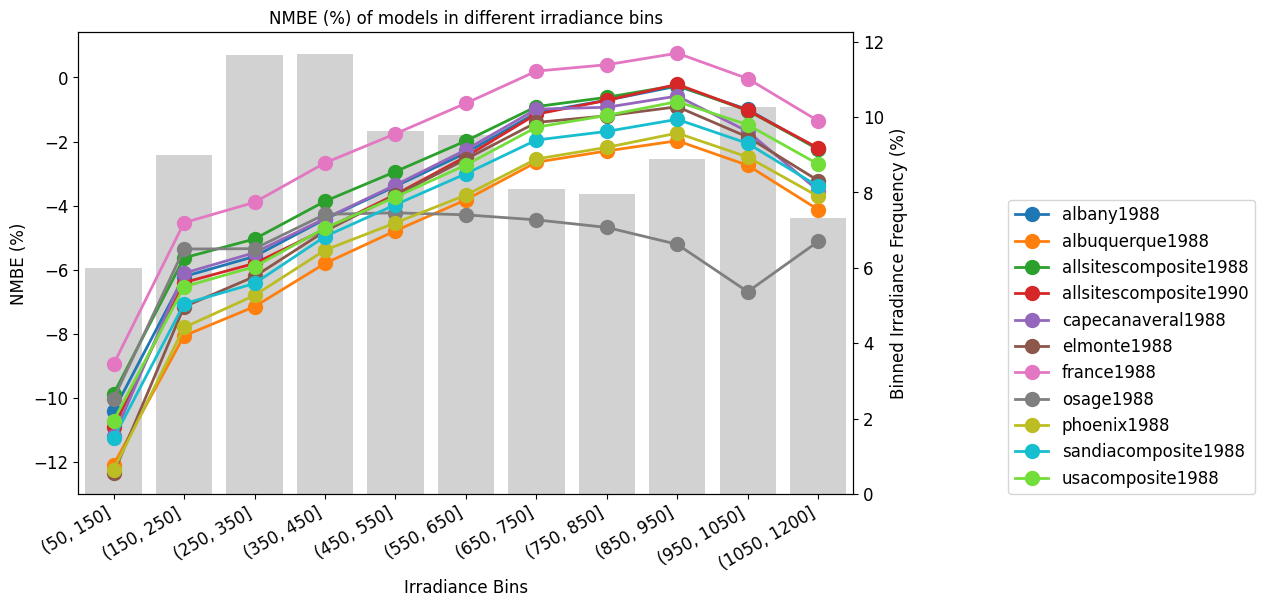

In [31]:
perez_solo_df['Irradiance Bins']=(pd.cut(x=perez_solo_df['Measured POA'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = perez_solo_df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins = bins.rename(columns = {'count':'Frequency'})
bins['Irradiance Bins'] = bins.index
bins.index.names = ['Index']
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
for model in models:
    y = perez_solo_df.loc[perez_solo_df['Model'] == model][['Irradiance Bins','% Diff']].groupby('Irradiance Bins', observed=False).mean().sort_values('Irradiance Bins')['% Diff']
    ax.plot(x, y, marker='o', zorder=6.5, linewidth=2, markersize=10, color = overall_perez.loc[overall_perez['Model'] == model]['Color'].iloc[0], label=model )
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('NMBE (%)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, errorbar=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
ax.legend(loc=(1.2,0))

plt.title('NMBE (%) of models in different irradiance bins')
plt.show()

Text(0.5, 0, 'MBE ($W/m^2$)')

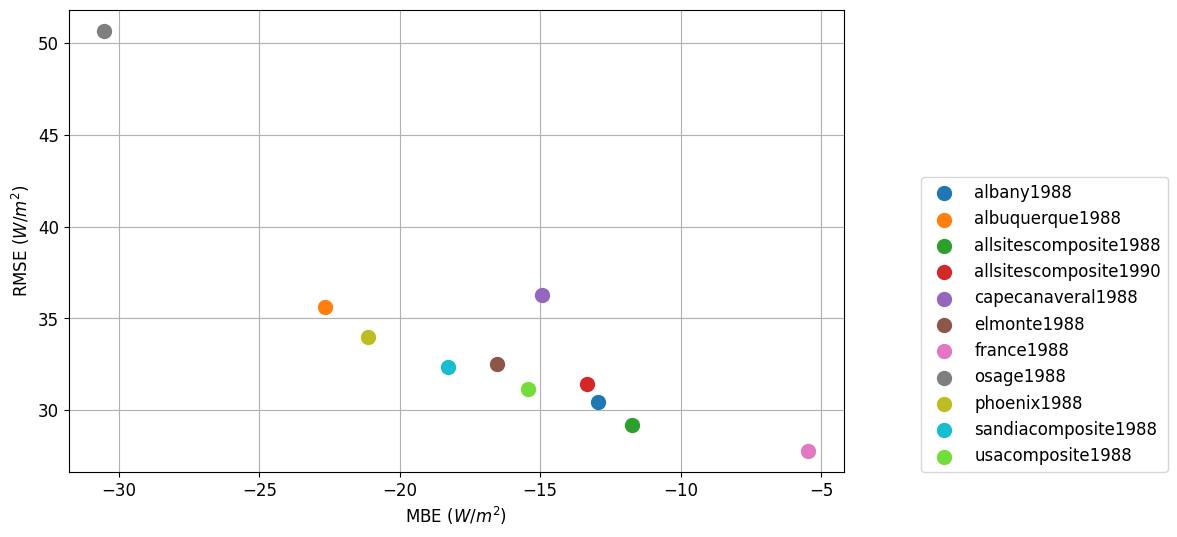

In [32]:
fig, ax = plt.subplots()
ax.grid(zorder=0)
for model in models:
    data = overall_perez.loc[overall_perez['Model'] == model]
    ax.scatter(data['Residuals'], data['RMSE'], color=data['Color'], zorder=2.5, s=100, label=model)
ax.legend(loc=(1.1,0))
ax.set_ylabel('RMSE ($W/m^2$)')
ax.set_xlabel('MBE ($W/m^2$)')



Text(0.5, 0, 'Residuals ($W/m^2$)')

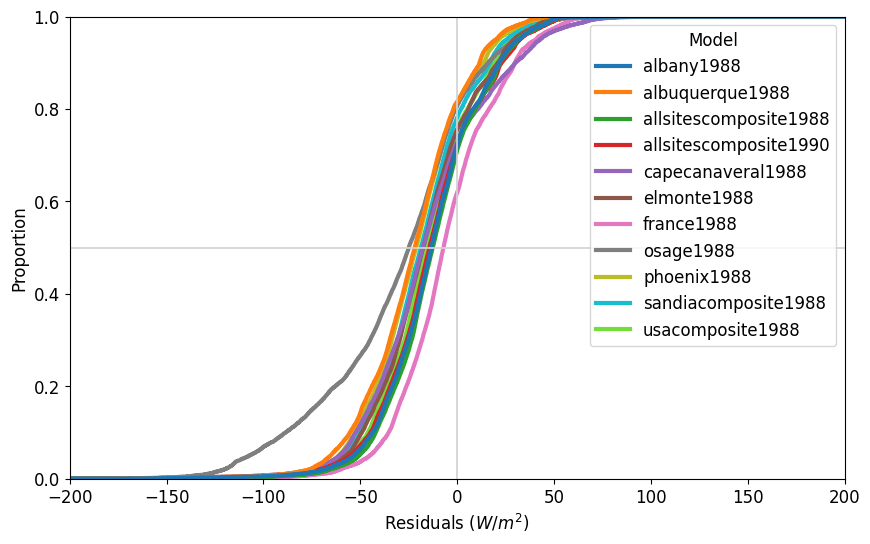

In [33]:
sns.ecdfplot(data=perez_solo_df.reset_index(), x='Residuals', hue='Model', linewidth=3,hue_order=models, palette=sns.color_palette(overall_perez['Color']))
plt.axvline(0, c='lightgrey')
plt.axhline(0.5, c='lightgrey')
ax.legend(loc=(1.1,0))
plt.xlim(-200,200)
plt.xlabel('Residuals ($W/m^2$)')

#### 2. Which POA transposition model has the best performance?

In [34]:
poa_results_df['% Diff'] = 100 * (poa_results_df['Modeled POA'] - poa_results_df['Measured POA']) / poa_results_df['Measured POA']
poa_results_df['Residuals'] = poa_results_df['Modeled POA'] - poa_results_df['Measured POA']
overall_poa = poa_results_df.groupby('Model').mean().reset_index()
overall_poa['Color'] =  ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd','#8c564b']
overall_poa

,Model,Modeled POA,Measured POA,Time,% Diff,Residuals,Color
0,Haydavies,573.795148,597.659164,2024-02-13 23:30:05.327184640-06:00,-5.504217,-23.864016,#1f77b4
1,Isotropic,556.659341,597.659164,2024-02-13 23:30:05.327184640-06:00,-8.233931,-40.999823,#ff7f0e
2,King,580.668316,597.659164,2024-02-13 23:30:05.327184640-06:00,-3.705863,-16.990848,#2ca02c
3,Klucher,579.826991,597.659164,2024-02-13 23:30:05.327184640-06:00,-4.542022,-17.832174,#d62728
4,Perez (france1988),592.205586,597.659164,2024-02-13 23:30:05.327184640-06:00,-1.939775,-5.453578,#9467bd
5,Reindl,575.220007,597.659164,2024-02-13 23:30:05.327184640-06:00,-5.212864,-22.439157,#8c564b


In [35]:
#find RMSE of each model
rmse = []
models = overall_poa['Model'].unique()
for model in models:
    x = poa_results_df.loc[poa_results_df['Model'] == model]
    val = sklearn.metrics.root_mean_squared_error(x[['Modeled POA','Measured POA']].dropna()['Modeled POA'],x[['Modeled POA','Measured POA']].dropna()['Measured POA'])
    rmse.append(val)
overall_poa['RMSE'] = rmse

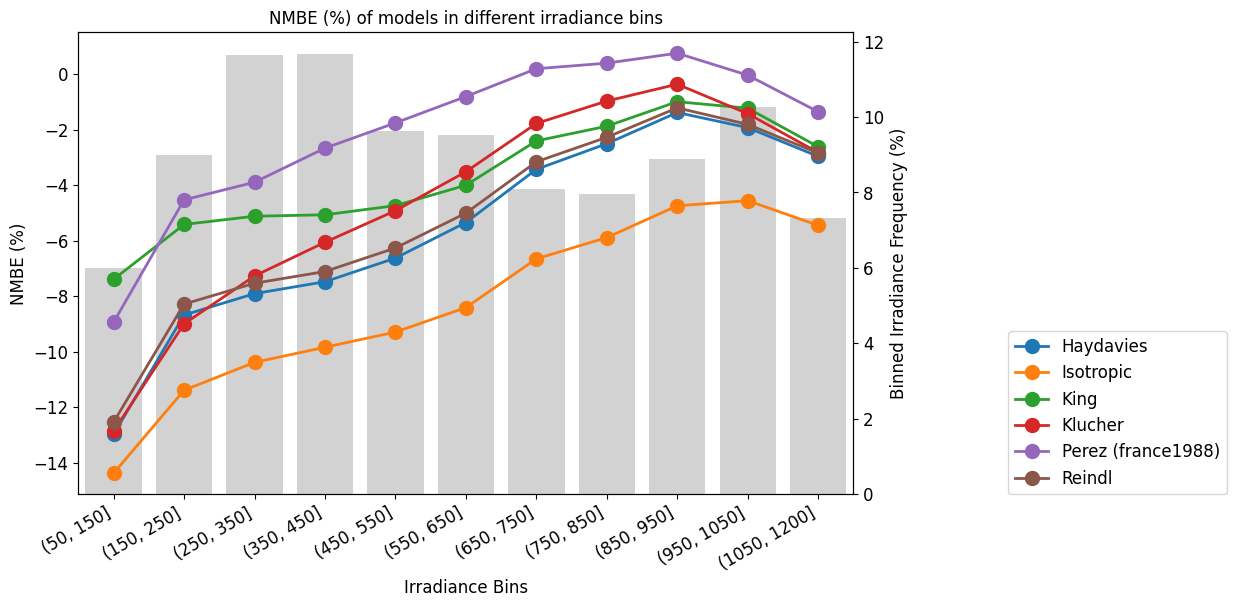

In [36]:
poa_results_df['Irradiance Bins']=(pd.cut(x=poa_results_df['Measured POA'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = poa_results_df['Irradiance Bins'].value_counts()
bins = bins.to_frame()
bins = bins.rename(columns = {'count':'Frequency'})
bins['Irradiance Bins'] = bins.index
bins.index.names = ['Index']
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Freq Norm'].sum()

fig, ax = plt.subplots()
x = binstr
for model in models:
    y = poa_results_df.loc[poa_results_df['Model'] == model][['Irradiance Bins','% Diff']].groupby('Irradiance Bins', observed=False).mean().sort_values('Irradiance Bins')['% Diff']
    ax.plot(x, y, marker='o', zorder=6.5, linewidth=2, markersize=10, color = overall_poa.loc[overall_poa['Model'] == model]['Color'].iloc[0], label=model )
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('NMBE (%)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, errorbar=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
ax.legend(loc=(1.2,0))

plt.title('NMBE (%) of models in different irradiance bins')
plt.show()

Text(0.5, 0, 'MBE ($W/m^2$)')

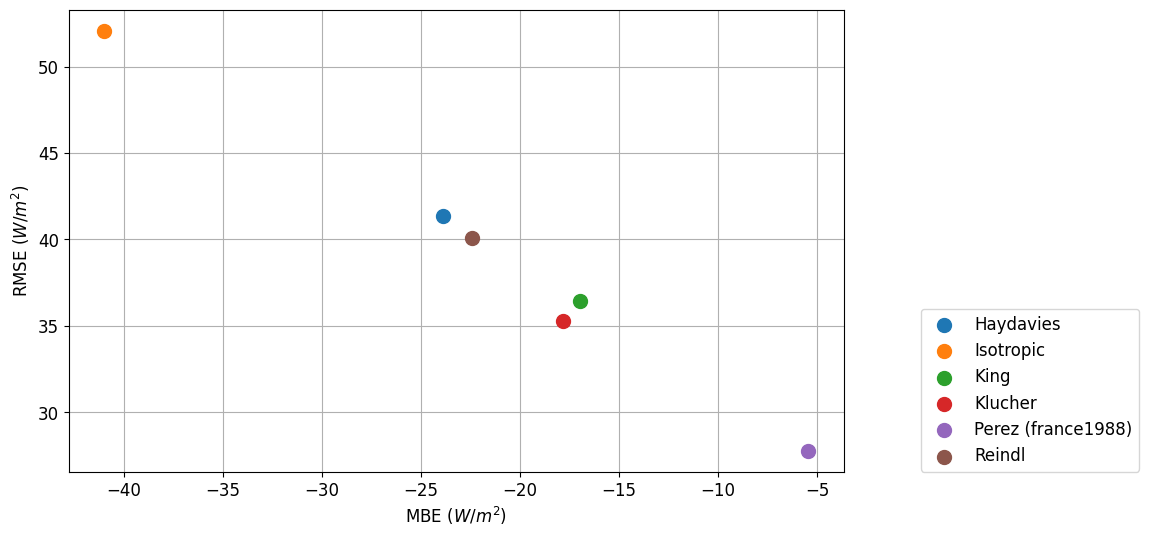

In [37]:
fig, ax = plt.subplots()
ax.grid(zorder=0)
for model in models:
    data = overall_poa.loc[overall_poa['Model'] == model]
    ax.scatter(data['Residuals'], data['RMSE'], color=data['Color'], zorder=2.5, s=100, label=model)
ax.legend(loc=(1.1,0))
ax.set_ylabel('RMSE ($W/m^2$)')
ax.set_xlabel('MBE ($W/m^2$)')



Text(0.5, 0, 'Residuals ($W/m^2$)')

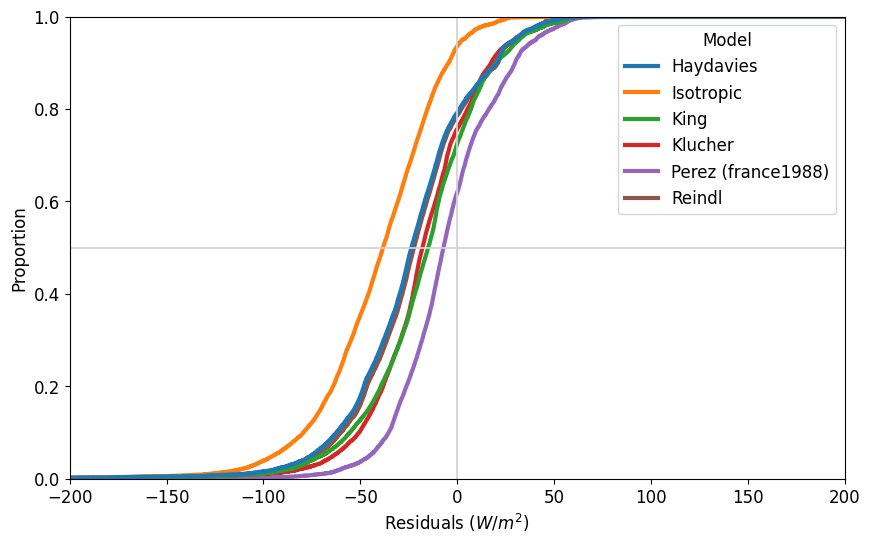

In [38]:
sns.ecdfplot(data=poa_results_df.reset_index(), x='Residuals', hue='Model', linewidth=3, hue_order=models,palette=sns.color_palette(overall_poa['Color']))
plt.axvline(0, c='lightgrey')
plt.axhline(0.5, c='lightgrey')
ax.legend(loc=(1.1,0))
plt.xlim(-200,200)
plt.xlabel('Residuals ($W/m^2$)')

In [39]:
temp_results_df['Diff'] = temp_results_df['Modeled Temp'] - temp_results_df['Measured Temp']
overall_temp = temp_results_df.groupby('Model').mean().reset_index()
overall_temp['Color'] =  ['#1f77b4', '#ff7f0e', '#2ca02c','#d62728','#9467bd']
overall_temp

,Model,Modeled Temp,POA Global,Air Temp,Measured Temp,Time,Diff,Color
0,Faiman,35.928620,597.659164,19.654392,33.021002,2024-02-13 23:30:05.327184640-06:00,2.189364,#1f77b4
1,PVSyst,34.362612,597.659164,19.654392,33.021002,2024-02-13 23:30:05.327184640-06:00,0.623413,#ff7f0e
2,Ross,36.538263,597.659164,19.654392,33.021002,2024-02-13 23:30:05.327184640-06:00,3.516957,#2ca02c
3,SAM NOCT,33.753363,597.659164,19.654392,33.021002,2024-02-13 23:30:05.327184640-06:00,0.014234,#d62728
4,SAPM,34.993493,597.659164,19.654392,33.021002,2024-02-13 23:30:05.327184640-06:00,1.254217,#9467bd


In [40]:
#find RMSE of each model
rmse = []
models = temp_results_df['Model'].unique()
for model in models:
    x = temp_results_df.loc[temp_results_df['Model'] == model]
    val = sklearn.metrics.root_mean_squared_error(x[['Modeled Temp','Measured Temp']].dropna()['Modeled Temp'],x[['Modeled Temp','Measured Temp']].dropna()['Measured Temp'])
    rmse.append(val)
overall_temp['RMSE'] = rmse

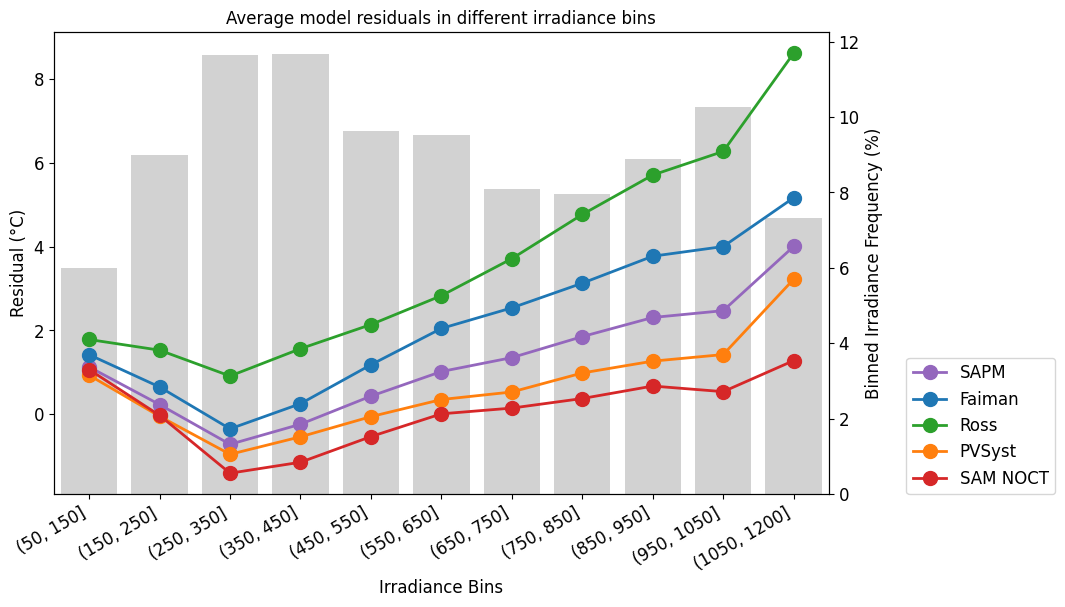

In [41]:
#plotting NMBE for each irradiance bin to see performance at different irradiance levels
temp_results_df['Irradiance Bins']=(pd.cut(x=temp_results_df['POA Global'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = temp_results_df['Irradiance Bins'].value_counts().to_frame()
bins.rename(columns = {'count' : 'Frequency'}, inplace = True)
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Irradiance Bins'] = bins.index
bins.index.names = ['Index']


fig, ax = plt.subplots()
x = binstr
for model in models:
    y = temp_results_df.loc[temp_results_df['Model'] == model][['Irradiance Bins','Diff']].groupby('Irradiance Bins', observed=False).mean().sort_values('Irradiance Bins')['Diff']
    ax.plot(x, y, marker='o', zorder=6.5, linewidth=2, markersize=10, color = overall_temp.loc[overall_temp['Model'] == model]['Color'].iloc[0], label=model )
             
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Residual (°C)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, errorbar=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
ax.legend(loc=(1.1,0))

plt.title('Average model residuals in different irradiance bins')
plt.show()

Text(0.5, 0, 'POA Global ($W/m^2$)')

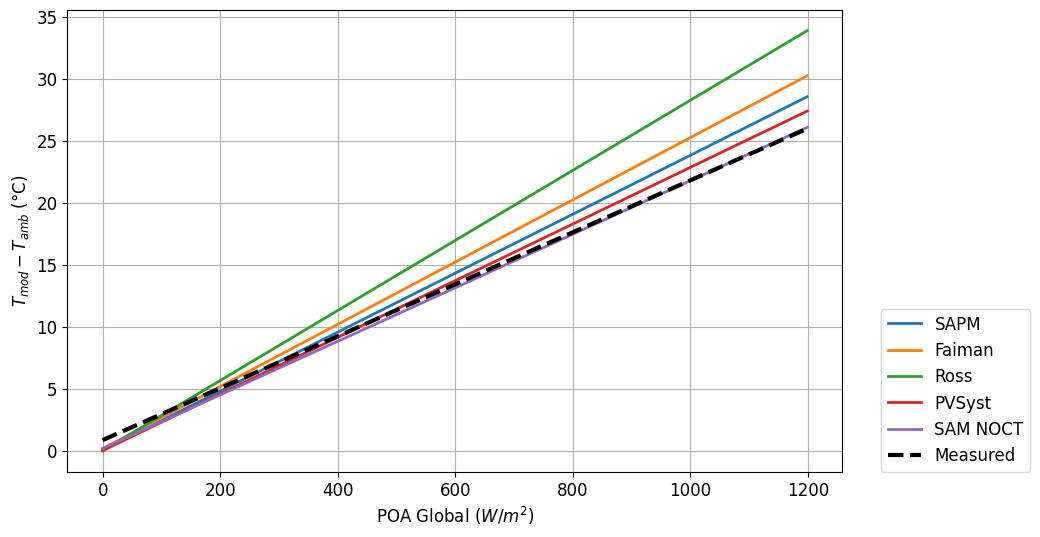

In [42]:
temp_results_df['Amb Diff'] = temp_results_df['Modeled Temp'] - temp_results_df['Air Temp']
temp_results_df['Meas Amb Diff'] = temp_results_df['Measured Temp'] - temp_results_df['Air Temp']
slope = []
intercept = []
for model in models:
    temp = temp_results_df.loc[temp_results_df['Model'] == model]
    z = np.polyfit(temp[['Amb Diff','POA Global']].dropna()['POA Global'], temp[['Amb Diff','POA Global']].dropna()['Amb Diff'], 1)
    slope.append(z[0])
    intercept.append(z[1])

fig, ax = plt.subplots()
x = np.arange(0,1200)
for i in np.arange(0,5):
    y = slope[i] * x + intercept[i]
    ax.plot(x,y,color=overall_temp['Color'][i], label=models[i], linewidth=2)
z = np.polyfit(temp[['Meas Amb Diff','POA Global']].dropna()['POA Global'], temp[['Meas Amb Diff','POA Global']].dropna()['Meas Amb Diff'], 1)
y = z[0] * x + z[1]
ax.plot(x, y, linestyle='--', c='black', label='Measured', linewidth=3)
ax.legend(loc=(1.05,0))
ax.grid(zorder=0)
ax.set_ylabel('$T_{mod} - T_{amb}$ (°C)')
ax.set_xlabel('POA Global ($W/m^2$)')


Text(0.5, 0, 'Residuals (°C)')

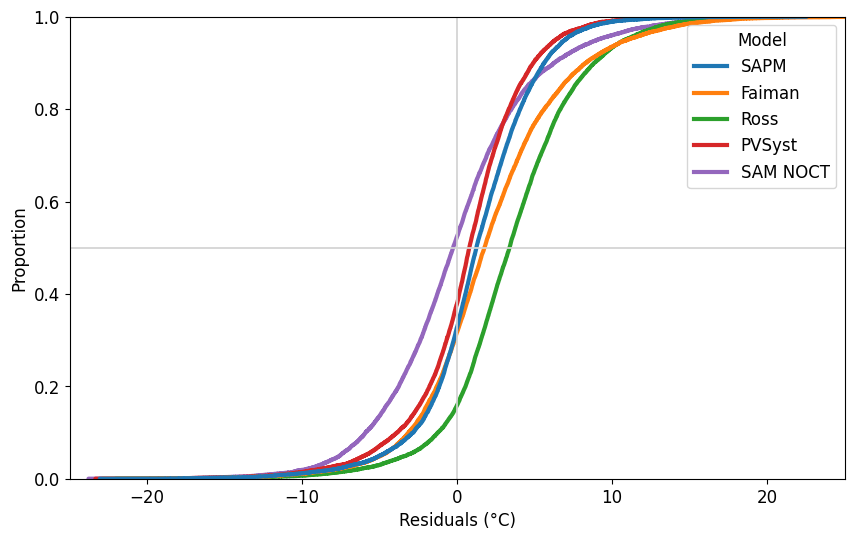

In [43]:
sns.ecdfplot(data=temp_results_df.reset_index(), x='Diff', hue='Model', linewidth=3, hue_order=models,palette=sns.color_palette(overall_temp['Color']))
plt.axvline(0, c='lightgrey')
plt.axhline(0.5, c='lightgrey')
ax.legend(loc=(1.1,0))
plt.xlim(-25,25)
plt.xlabel('Residuals (°C)')

In [44]:
#convert the measured power into watts 
results_df['Modeled Power'] = results_df['Modeled Power']/1000
results_df['Modeled Power'] = results_df['Modeled Power']*0.85
results_df['% Diff'] = 100 * (results_df['Modeled Power'] - results_df['Measured Power']) / results_df['Measured Power']
results_df['Residuals'] = results_df['Modeled Power'] - results_df['Measured Power']
overall_results = results_df.groupby(['System','Model Name']).mean().reset_index()
overall_results['% Diff'] = 100 * (overall_results['Modeled Power'] - overall_results['Measured Power']) / overall_results['Measured Power']
overall_results

,System,Model Name,Modeled Power,Measured Power,Irradiance,Module Temperature,Time,Year,% Diff,Residuals
0,cigs,CEC,10.383472,4.037999,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,157.143996,6.315688
1,cigs,DES,10.381934,4.037999,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,157.105897,6.314139
2,cigs,PVW,9.964824,4.037999,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,146.776277,5.900222
3,monoSi,CEC,14.209830,13.043137,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,8.944879,0.948815
4,monoSi,DES,14.213134,13.043137,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,8.970210,0.952122
5,monoSi,PVW,14.124341,13.043137,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,8.289448,0.863912
6,polySi,CEC,16.830395,15.927635,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,5.667882,0.792460
7,polySi,DES,16.839730,15.927635,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,5.726491,0.801823
8,polySi,PVW,16.784786,15.927635,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,5.381534,0.749402


In [45]:
results_df = results_df.loc[results_df['System'] != 'cigs']
overall_results = overall_results.loc[overall_results['System'] != 'cigs']
overall_results['Color'] = ['#1f77b4','#1bb667','#8935d6', '#ff7f0e','#bd9f0c','#e04743']

In [46]:
#find RMSE of each model
rmse = []
models = results_df['Model Name'].unique()
systems = results_df['System'].unique()
for system in systems:
    y = results_df.loc[results_df['System'] == system]
    for model in models:
        x = y.loc[y['Model Name'] == model]
        val = sklearn.metrics.root_mean_squared_error(x[['Modeled Power','Measured Power']].dropna()['Modeled Power'],x[['Modeled Power','Measured Power']].dropna()['Measured Power'])
        rmse.append(val)
overall_results['RMSE'] = rmse

<Axes: xlabel='System', ylabel='% Diff'>

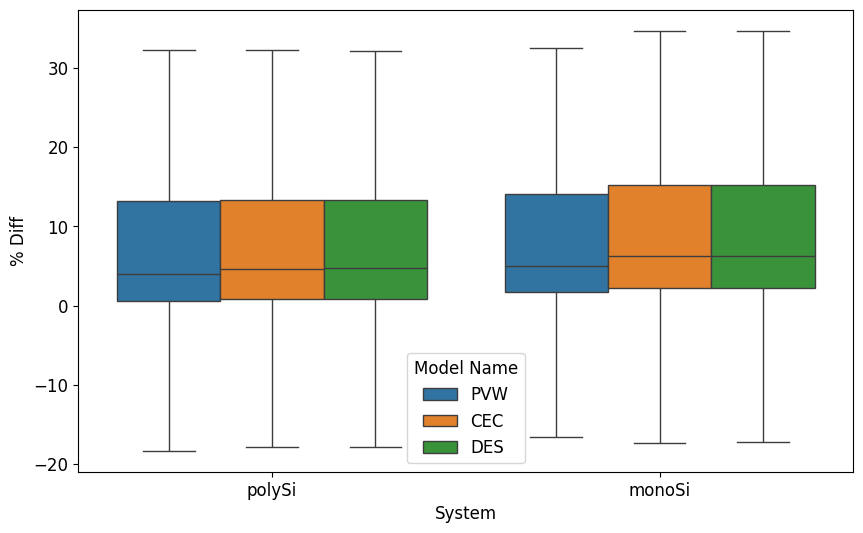

In [47]:
sns.boxplot(data=results_df.reset_index(), x='System', y='% Diff', hue='Model Name', showfliers=False)

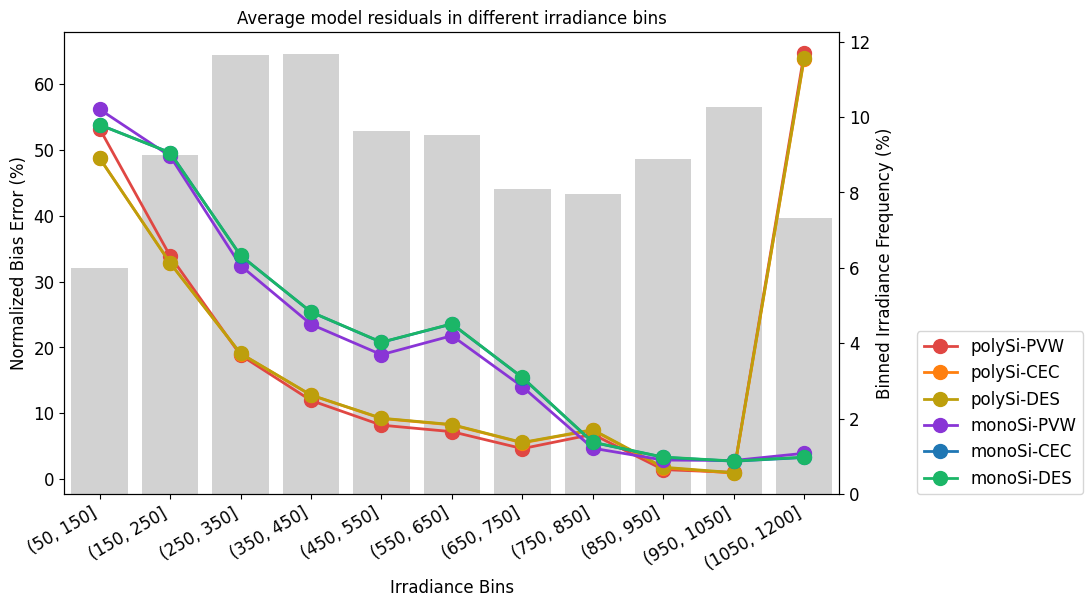

In [48]:
#plotting NMBE for each irradiance bin to see performance at different irradiance levels
results_df['Irradiance Bins']=(pd.cut(x=results_df['Irradiance'], bins=[50,150,250,350,450,550,650,750,850,950,1050,1200]))
binstr = ['(50, 150]','(150, 250]','(250, 350]','(350, 450]','(450, 550]','(550, 650]','(650, 750]','(750, 850]','(850, 950]','(950, 1050]','(1050, 1200]']

bins = results_df['Irradiance Bins'].value_counts().to_frame()
bins.rename(columns = {'count' : 'Frequency'}, inplace = True)
bins['Freq Norm'] =( bins['Frequency']/bins['Frequency'].sum()) * 100
bins['Irradiance Bins'] = bins.index
bins.index.names = ['Index']


fig, ax = plt.subplots()
x = binstr
for system in systems:
    p = results_df.loc[results_df['System'] == system]
    oc = overall_results.loc[overall_results['System'] == system]
    for model in models:
        y = p.loc[p['Model Name'] == model][['Irradiance Bins','% Diff']].groupby('Irradiance Bins', observed=False).mean().sort_values('Irradiance Bins')['% Diff']
        ax.plot(x, y, marker='o', zorder=6.5, linewidth=2, markersize=10, color = oc.loc[oc['Model Name'] == model]['Color'].iloc[0], label=(system+'-'+model) )
                 
plt.xticks(rotation=30, ha='right')
ax.set_ylabel('Normalized Bias Error (%)')
ax.set_xlabel('Irradiance Bins')

ax2 = ax.twinx()
ax2 = sns.barplot(x='Irradiance Bins', y='Freq Norm', data=bins, errorbar=None, color='grey', alpha=0.35, zorder=2.5)
ax2.set_ylabel('Binned Irradiance Frequency (%)')
plt.grid(False)
plt.xticks(rotation=30, ha='right')
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)
ax.legend(loc=(1.1,0))

plt.title('Average model residuals in different irradiance bins')
plt.show()

In [51]:
overall_results

,System,Model Name,Modeled Power,Measured Power,Irradiance,Module Temperature,Time,Year,% Diff,Residuals,Color,RMSE
3,monoSi,CEC,13.659278,13.043137,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,4.723870,0.405872,#1f77b4,1.712238
4,monoSi,DES,13.661924,13.043137,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,4.744162,0.408534,#1bb667,1.712673
5,monoSi,PVW,13.574981,13.043137,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,4.077580,0.322152,#8935d6,1.710875
6,polySi,CEC,16.207757,15.927635,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,1.758716,0.173907,#ff7f0e,1.714949
7,polySi,DES,16.215248,15.927635,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,1.805748,0.181435,#bd9f0c,1.739979
8,polySi,PVW,16.160256,15.927635,597.659164,33.021002,2024-02-13 23:30:05.327184640-06:00,2023.855642,1.460482,0.128861,#e04743,1.739919


Text(0.5, 0, 'MBE (kW)')

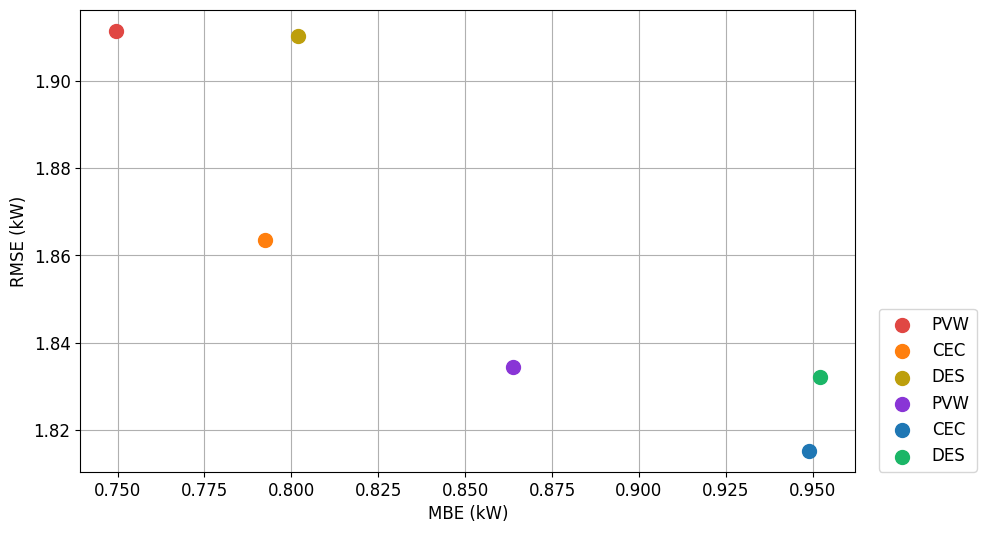

In [82]:
fig, ax = plt.subplots()
ax.grid(zorder=0)
for system in systems:
    for model in models:
        data = overall_results.loc[(overall_results['Model Name'] == model) & (overall_results['System'] == system)]
        ax.scatter(data['Residuals'], data['RMSE'], color=data['Color'], zorder=2.5, s=100, label=model)
ax.legend(loc=(1.03,0))
ax.set_ylabel('RMSE (kW)')
ax.set_xlabel('MBE (kW)')
# ax.set_ylim(1,3)
# ax.set_xlim(0,0.5)

Text(0.5, 0, 'Residuals (kW)')

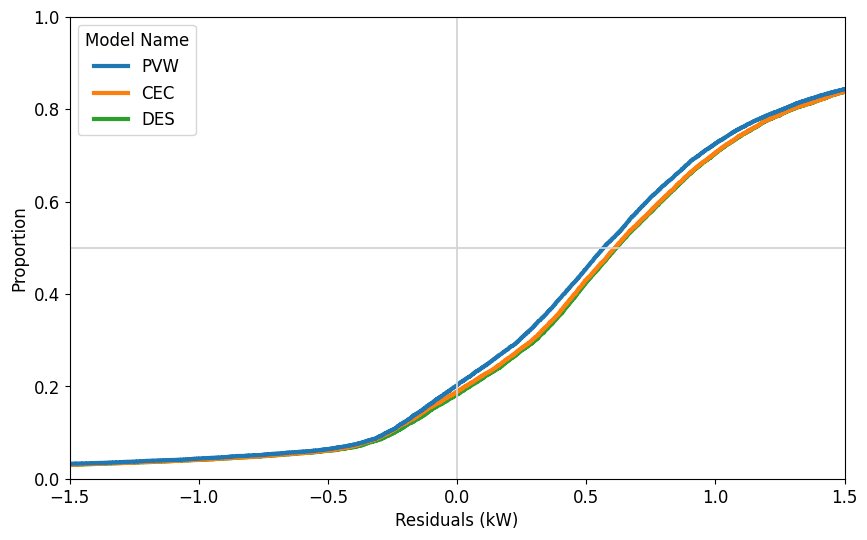

In [84]:
poly_df = results_df.loc[results_df['System'] == 'polySi']
sns.ecdfplot(data=poly_df.reset_index(), x='Residuals', hue='Model Name', linewidth=3, palette='tab10')
plt.axvline(0, c='lightgrey')
plt.axhline(0.5, c='lightgrey')
ax.legend(loc=(1.1,0))
plt.xlim(-1.5,1.5)
plt.xlabel('Residuals (kW)')

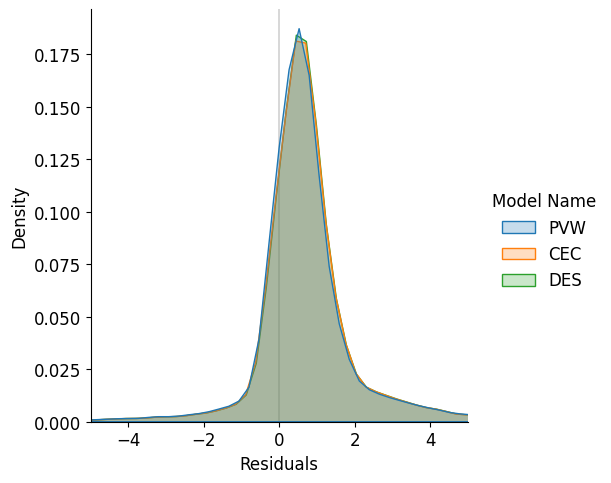

In [89]:
sns.displot(data=poly_df.reset_index(), x='Residuals', hue='Model Name', kind='kde', palette='tab10', fill=True)
plt.xlim(-5,5)
plt.axvline(0,c='lightgrey', zorder=0)

Text(0.5, 0, 'Residuals (kW)')

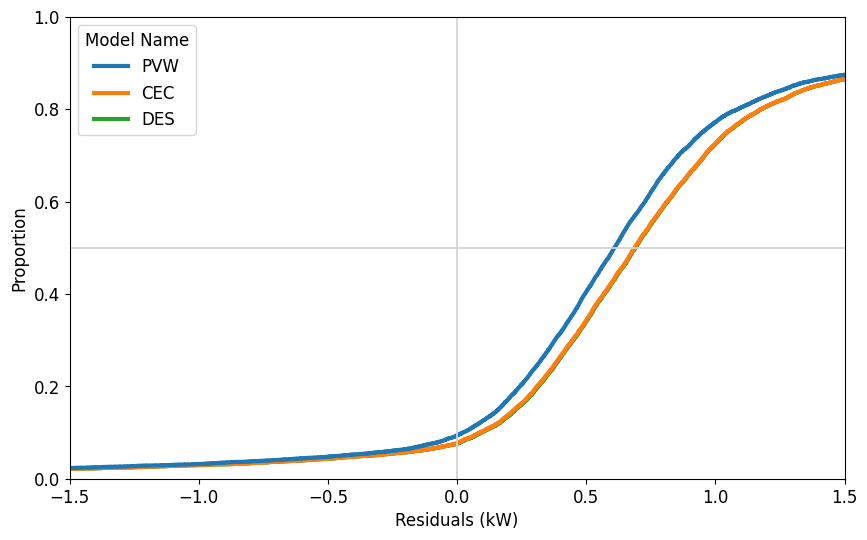

In [86]:
mono_df = results_df.loc[results_df['System'] == 'monoSi']
sns.ecdfplot(data=mono_df.reset_index(), x='Residuals', hue='Model Name', linewidth=3, palette='tab10')
plt.axvline(0, c='lightgrey')
plt.axhline(0.5, c='lightgrey')
ax.legend(loc=(1.1,0))
plt.xlim(-1.5,1.5)
plt.xlabel('Residuals (kW)')

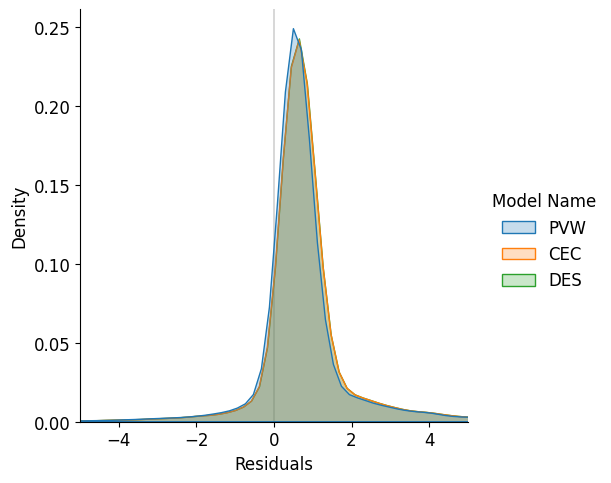

In [88]:
sns.displot(data=mono_df.reset_index(), x='Residuals', hue='Model Name', kind='kde', palette='tab10', fill=True)
plt.xlim(-5,5)
plt.axvline(0,c='lightgrey', zorder=0)